In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    read_and_window_session,
    read_session,
    train_loop,
    optimization_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    summary
)
from lib.models import  MLP, MLP2hl, LSTM
from tqdm import tqdm
import plotly.express as px
from tabulate import tabulate

/home/mmazeem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 505
DEVICE = 'cuda'

In [4]:
train_sessions = [25, 67, 42]
test_sessions = [58, 62, 24]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [5]:
model = LSTM(WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [7]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

optimization_loop(model, trainloader, testloader, criterion, optimizer, 30, DEVICE, Path('dev/lstm'))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.037265: Dev Loss: 1.8153: 100%|██████████| 30/30 [10:56<00:00, 21.88s/it]


In [6]:
model.load_state_dict(torch.load(Path('dev/lstm/best_model.pt')))

<All keys matched successfully>

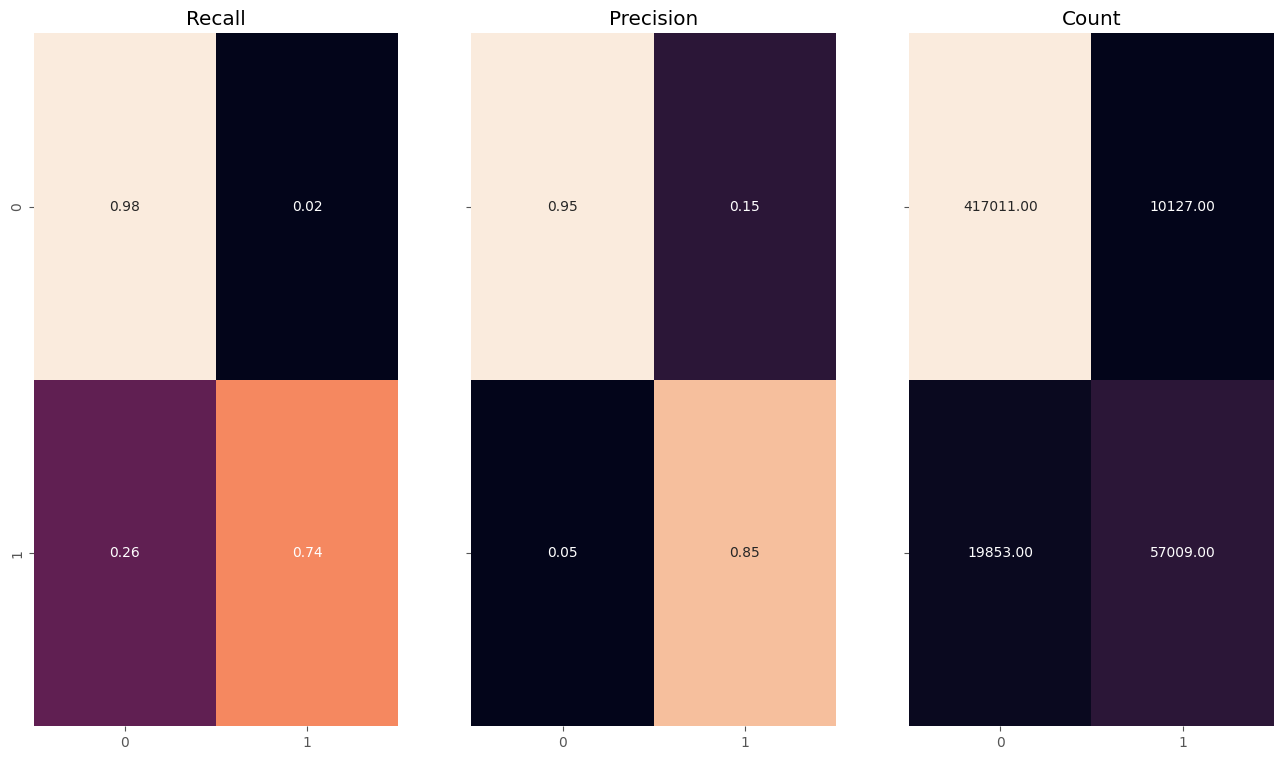

Metric        Value
---------  --------
loss       0.149433
precision  0.849157
recall     0.741706
f1         0.791803


In [11]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

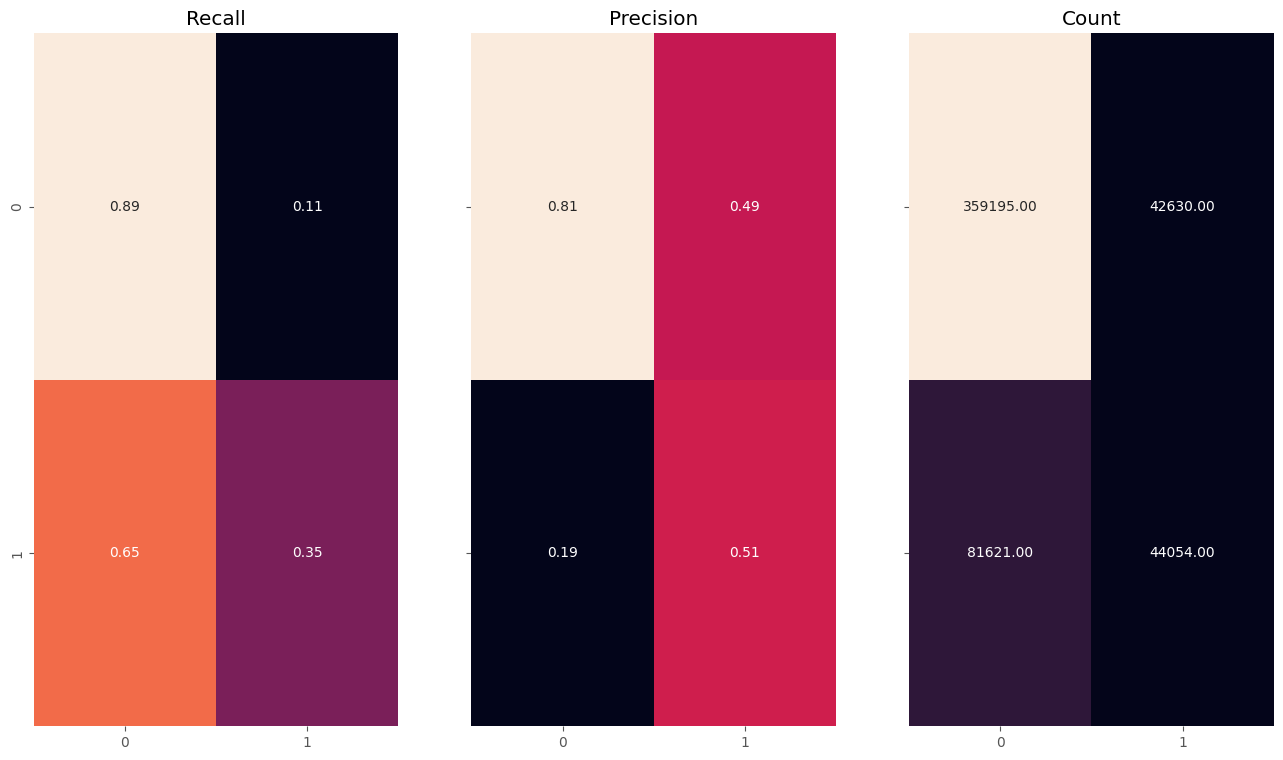

Metric        Value
---------  --------
loss       0.77043
precision  0.508214
recall     0.350539
f1         0.414901


In [12]:
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [7]:
test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=raw_dir,
    labelpath=label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE
)

: 

Gtk-Message: 12:50:07.555: Failed to load module "xapp-gtk3-module"
Gtk-Message: 12:50:07.556: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 12:50:07.556: Failed to load module "appmenu-gtk-module"

(brave:43847): Gtk-WARNING **: 12:50:07.635: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 12:50:07.635: Failed to load module "canberra-gtk-module"

(brave:43847): Gtk-WARNING **: 12:50:07.636: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 12:50:07.636: Failed to load module "canberra-gtk-module"


Opening in existing browser session.


In [ ]:
def predict_and_plot_pretty_session(
    session_idx, 
    dim_factor, 
    datapath, 
    labelpath,
    winsize,
    model,
    criterion,
    batch_size,
    device
):
    session = read_session(session_idx, datapath)
    labels = read_labels(session_idx, labelpath)
    X,y = read_and_window_session(session_idx, winsize, datapath, labelpath)
    ys, metrics = evaluate_loop(
        model, 
        criterion, 
        DataLoader(TensorDataset(X, y), batch_size), 
        device
    )
    pred_bouts = get_bouts(ys['pred'])

    summary(metrics)

    session['Predicted Eating'] = ys['pred']
    session['Confidence'] = ys['conf']

    fig = px.line(
        session[::dim_factor], 
        x=session.index[::dim_factor], 
        y=['x_acc','y_acc','z_acc', 'Predicted Eating', 'Confidence']
    )
    fig.add_vrect(
        x0=labels['start'], 
        x1=labels['end'], 
        fillcolor='black', 
        opacity=.2,
        line_width=0,
        layer="below"
    )
    for bout in pred_bouts:
        fig.add_vrect(
            x0=bout['start'], 
            x1=bout['end'], 
            fillcolor='red', 
            opacity=.2,
            line_width=0,
            layer="below"
        )
    fig.show(renderer='browser')